In [1]:
import torch, torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
%matplotlib inline


In [2]:
dataset = MNIST(root='../../datasets/', download=True)

In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='../../datasets/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0], test_dataset[0]

((<PIL.Image.Image image mode=L size=28x28 at 0x7FD84AFE1BE0>, 5),
 (<PIL.Image.Image image mode=L size=28x28 at 0x7FD84AFE1C18>, 7))

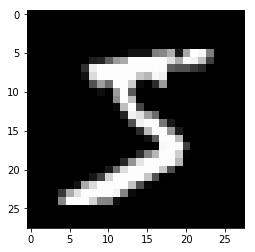

In [6]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')

In [7]:
def split_indices(n, val_pct, targets=None, stratify=False):
    if targets and stratify:
        return train_test_split(
            np.arange(n),
            test_size=val_pct,
            shuffle=True,
            stratify=targets)
    elif not targets:
        n_val = int(val_pct*n)
        idxs = np.random.permutation(n)
        return idxs[n_val:], idxs[:n_val]
    else:
        assert False

In [8]:
df = MNIST(root="../../datasets/", train=True, 
           transform=transforms.ToTensor())


In [9]:
img_tensor, label = df[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [10]:
# unstratified data
# ti, vi = split_indices(len(df), .2)
# len(ti), len(vi)

In [11]:
# stratified training data
# ti, vi = split_indices(len(df), .2, targets=[i[1] for i in df], stratify=True)
# len(ti), len(vi)

In [12]:


# lets start using tdf and vdf instead of df, tdf 
ti, vi = split_indices(len(df), .2, targets=[i[1] for i in df], stratify=True)


In [13]:

BATCH_SIZE = 128
train_sampler = SubsetRandomSampler(ti)
val_sampler = SubsetRandomSampler(vi)


tdl = DataLoader(df, BATCH_SIZE, sampler=train_sampler)
vdl = DataLoader(df, BATCH_SIZE, sampler=val_sampler)

In [14]:

INPUT_SIZE = 28 * 28
NUM_CLASSES = 10


In [15]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(INPUT_SIZE, NUM_CLASSES)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
model = MnistModel()

In [16]:
print(model.parameters())

<generator object Module.parameters at 0x7fd84afd9f10>


In [17]:
for images, labels in tdl:
    outputs = model(images)
    break

outputs.shape, outputs[0].data

(torch.Size([128, 10]),
 tensor([ 0.1680,  0.3099,  0.2513, -0.2111, -0.0542,  0.2912,  0.2971, -0.0871,
          0.0902,  0.1304]))

In [18]:
def accuracy(pred, true):
    _, ops = torch.max(pred, dim=1)
    return torch.sum(ops == true).item() / len(true)

In [19]:
loss_func = F.cross_entropy

In [20]:
LEARNING_RATE = .001
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [21]:
def loss_batch(m, l_func, xb, yb, opt=None, metric=None):
    preds = m(xb)
    loss = l_func(preds, yb)
    
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [22]:
def evaluate(m, l_func, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(m, l_func, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [23]:
val_loss, total, val_acc = evaluate(model, loss_func, vdl, metric=accuracy)
print("loss : {:.4f}, Accuracy: {:.4f}".format(val_loss, val_acc))

loss : 2.3074, Accuracy: 0.1144


In [24]:
def fit(epochs, m, loss_f, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(m, loss_f, xb, yb, opt)
        result = evaluate(m, loss_f, valid_dl, metric)
        val_loss, total, val_metric = result
        if metric is None:
            print("epoch [{}/{}] loss : {:.4f} ".format(epoch + 1, epochs, val_loss))
        else:
            print("epoch [{}/{}] loss : {:.4f}, {}: {:.4f} ".format(epoch + 1, epochs, val_loss, metric.__name__, val_acc))
        
            

In [25]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [26]:
fit(5, model, F.cross_entropy, optimizer, tdl, vdl, accuracy)

epoch [1/5] loss : 1.9618, accuracy: 0.1144 
epoch [2/5] loss : 1.6985, accuracy: 0.1144 
epoch [3/5] loss : 1.5005, accuracy: 0.1144 
epoch [4/5] loss : 1.3498, accuracy: 0.1144 
epoch [5/5] loss : 1.2330, accuracy: 0.1144 


In [27]:
def predict_image(img, m):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    
    return preds[0].item()

In [28]:
test_df = MNIST(root='../../datasets/', train=False, transform=transforms.ToTensor())

(1, 1)

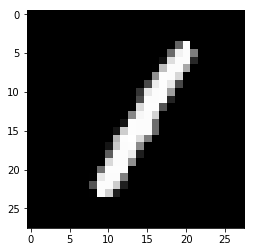

In [29]:
img, label = test_df[1820]
plt.imshow(img[0], cmap='gray')
label, predict_image(img, model) 